In [1]:
import string
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson
from sklearn.utils import check_random_state
from sklearn import cluster
from scipy.stats import poisson
from hmmlearn.base import _BaseHMM

In [2]:
def normalize(A, axis=None):
    """Normalize the input array so that it sums to 1.
    Parameters
    ----------
    A: array, shape (n_samples, n_features)
        Non-normalized input data.
    axis: int
        Dimension along which normalization is performed.
    Returns
    -------
    normalized_A: array, shape (n_samples, n_features)
        A with values normalized (summing to 1) along the prescribed axis
    WARNING: Modifies the array inplace.
    """
    A += np.finfo(float).eps
    Asum = A.sum(axis)
    if axis and A.ndim > 1:
        # Make sure we don't divide by zero.
        Asum[Asum == 0] = 1
        shape = list(A.shape)
        shape[axis] = 1
        Asum.shape = shape
    A /= Asum
    # TODO: should return nothing, since the operation is inplace.
    return A

# Implement the Hidden Markov Model with Poisson emissions

In [3]:

__all__ = ['GMMHMM',
           'GaussianHMM',
           'MultinomialHMM']

NEGINF = -np.inf


class PoissonHMM(_BaseHMM):
    """Hidden Markov Model with Poisson emissions
    Representation of a hidden Markov model probability distribution.
    This class allows for easy evaluation of, sampling from, and
    maximum-likelihood estimation of the parameters of a HMM.
    """
    def __init__(self, n_components=1, startprob=None,
                 transmat=None, startprob_prior=None, transmat_prior=None,
                 algorithm="viterbi", means_prior=0, 
                 random_state=None, n_iter=10, thresh=1e-2,
                 params=string.ascii_letters,
                 init_params=string.ascii_letters):
        _BaseHMM.__init__(self, n_components, startprob, transmat,
                          startprob_prior=startprob_prior,
                          transmat_prior=transmat_prior, algorithm=algorithm,
                          random_state=random_state, n_iter=n_iter,
                          thresh=thresh, params=params,
                          init_params=init_params)
        self.means_prior = means_prior
 

    def _get_means(self):
        """lambda parameters for each state."""
        return self._means_


    def _set_means(self, means):
        means = np.asarray(means)
        if (hasattr(self, 'n_features')
                and means.shape != (self.n_components, self.n_features)):
            raise ValueError('means must have shape '
                             '(n_components, n_features)')
        self._means_ = means.copy()
        self.n_features = self._means_.shape[1]

    
    means_ = property(_get_means, _set_means)


    def _compute_log_likelihood(self, obs):
        all_obs = np.concatenate(obs)
        logp = np.empty([1, len(all_obs)])

        for lam in self._means_:
            p = poisson.logpmf(all_obs, lam)
            logp = np.vstack((logp,p))
        logp = logp[1:,:]


        return logp.T 



    def _init(self, obs, params='stmc'):
        super(PoissonHMM, self)._init(obs, params=params)

        all_obs = np.concatenate(obs)
        _, n_features = all_obs.shape

        if hasattr(self, 'n_features') and self.n_features != n_features:
            raise ValueError('Unexpected number of dimensions, got %s but '
                             'expected %s' % (n_features, self.n_features))

        self.n_features = n_features
        if 'm' in params:
            self._means_ = self.means_prior

                     

    def _initialize_sufficient_statistics(self):
        stats = super(PoissonHMM, self)._initialize_sufficient_statistics()

        stats['post'] = np.zeros(self.n_components)
        stats['obs'] = np.zeros((self.n_components, self.n_features)) # expected number in state

        return stats

    def _accumulate_sufficient_statistics(self, stats, obs, framelogprob,
                                          posteriors, fwdlattice, bwdlattice,
                                          params):

        super(PoissonHMM, self)._accumulate_sufficient_statistics(
            stats, obs, framelogprob, posteriors, fwdlattice, bwdlattice,
            params)

        if 'm' in params or 'c' in params:
            stats['post'] += posteriors.sum(axis=0)
            stats['obs'] += np.dot(posteriors.T, obs)

    def _do_mstep(self, stats, params):
        super(PoissonHMM, self)._do_mstep(stats, params)

        denom = stats['post'][:, np.newaxis]
        if 'm' in params:
            self._means_ = ((stats['obs']) / (denom))
        self._means_ = np.maximum(self._means_, np.array([[self.means_prior[0]],[self.means_prior[0]],[self.means_prior[0]]]))



    def fit(self, obs):
        """Estimate model parameters.
        An initialization step is performed before entering the EM
        algorithm. If you want to avoid this step, pass proper
        ``init_params`` keyword argument to estimator's constructor.
        Parameters
        ----------
        obs : list
            List of array-like observation sequences, each of which
            has shape (n_i, n_features), where n_i is the length of
            the i_th observation.
        """
        
        return super(PoissonHMM, self).fit(obs)

# Read the data sequence

We are given a data sequence consisting on number of earthquakes for each year between the years 1900 and 2006.

In [4]:
state_seq = []
observation_seq = []
f = open('earthquakes.txt','r')
line = f.readline()
while line:
    line=line.rstrip().split('	')
    state_seq.append(int(line[0]))
    observation_seq.append(int(line[1]))
    line = f.readline()
    
state_seq = np.array(state_seq)
observation_seq = np.array(observation_seq)

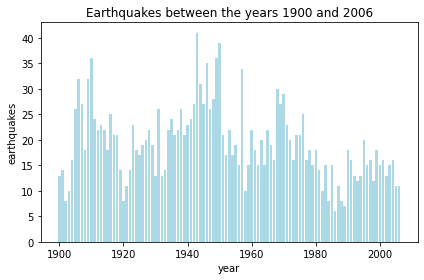

In [5]:
fig, ax = plt.subplots()

# the histogram of the data
plt.bar(state_seq, observation_seq, color='lightblue')

ax.set_xlabel('year')
ax.set_ylabel('earthquakes')
ax.set_title(r'Earthquakes between the years 1900 and 2006')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()


# Direct maximization of the likelihood

The likelihood of a mixture model with m components is given, for both discrete and continuous cases by:
\begin{equation}
L(\theta_1,...,\theta_m,\delta_1,...,\delta_m|x_1,...,x_n) = \prod_{j=1}^n\sum_{i=1}^m\delta_ip_i(x_j,\theta_i)
\end{equation}
- Where $\theta_1,...,\theta_m$ are the paramenter vectors for the component distributions,
- $\delta_1,...,\delta_m$ are the mixing parameters, totalling 1,
- $x_1,...,x_n$ the $n$ observations.
Supose $m = 2$, and the two components are Poisson-distributed, which means $\lambda_1$ and $\lambda_2$. Let $\delta_1$ and $\delta_2$ be the mixing parameters (with $\delta_1+\delta_2 =1$). The mixture distribution $p$ is then given by:
\begin{equation}
p(x) = \delta_1\frac{\lambda^x_1e^{-\lambda_1}}{x!}+\delta_2\frac{\lambda^x_2e^{-\lambda_2}}{x!}
\end{equation}
Since $\delta_2 = 1 - \delta_1$, there are only three parameters to be estimated: $\lambda_1,\lambda_2$ and $\delta_1$. The likelihood is:
\begin{equation}
L(\lambda_1,\lambda_2,\delta_1|x_1,...,x_n) = \prod_{i=1}^n\delta_1\frac{\lambda^x_1e^{-\lambda_1}}{x_i!}+(1-\delta_1)\frac{\lambda^x_2e^{-\lambda_2}}{x_i!}
\end{equation}

The analytic maximization of $L$ with respect to $\lambda_1,\lambda_2$ and $\delta_1$ would be awkward, as $L$ is the product of $n$ factors, each of which is a sum. Therefore parameter estimation is more conveniently carried out by direct numerical maximization of the likelihood or its logarithm.
However, the parameters $\delta$ and $\lambda$ are constrained by $\sum^m_{i=1}\delta_i = 1$ and (for i=1,...,$m$)$\delta_i>0$ and $\lambda_i>0$. It is therefore necessary to reparametrize when using an unconstrained optimizer.
One possibility is to maximize the likelihood with respect to the 2m-1 unconstrained 'working parameters'.
\begin{equation}
\eta_i = log\lambda_i \; (i=1,...,m)
\end{equation}
and
\begin{equation}
\tau_i = log\left( \frac{\delta_i}{1-\sum^m_{j=2}\delta_j}\right) \; (i=2,...,m)
\end{equation}
and
\begin{equation}
\delta_1 = 1 - \sum^m_{j=2}\delta_i
\end{equation}

## Hidden Markov Models

### The likelihood

Consider a HMM in general with observation sequence $x_1,x_2,...,x_T$. The probability $L_T$ of observed that sequence is calculated under an m-state HMM which has initial distribution $\delta$ and transition probability matrix $\daleth$ for the markov chainm and state-dependent probability (density) functions $p_i$.

The likelihood is then given by:
\begin{equation}
L_T = \delta P(x_1)\daleth P(x_2)...\daleth P(x_T)1'
\end{equation}
If $\delta$, the distribution of $C_1$, is the stationary distribution of the Markov chain, then in addition:
\begin{equation}
L_T = \delta\daleth P(x_1)\daleth P(x_2)...\daleth P(x_T)1'
\end{equation}

#### The forward algorithm
The forward algorithm is a recursive computation of the likelihood, which is computationally much more efficient than the brute-force summation. This computational inexpensiveness is the key feature of HMMs.

We state the forward algorithm by the vector $\alpha_t$, for $t=1,2,...,T$ by:
\begin{equation}
\alpha_t = \delta P(x_1)\daleth P(x_2)...\daleth P(x_t) = \delta P(x_1)\prod_{s=2}^t\daleth P(x_s)
\end{equation}
So then the likelihood:
\begin{equation}
L_T = \alpha_T1'
\end{equation}
and:
\begin{equation}
\alpha_t = \alpha_{t-1}\daleth P(x_t) \;  for \; t\ge 2
\end{equation}
- **Numerical (over/under)flow:** for discrete state-dependent distributions, the elements of $\alpha_t$, being made up of products of probabilities, become progressively smaller as $t$ increases. For the continous case, it reaches $\inf$. The solution is the same for over and underflow: scaling the vector $\alpha_t$ at eacht time $t$ so that its elemets sum up to 1.

The elements of the vector $\alpha_t$ are referred as **forward probabilities**.

The number of operations is of order Tm^2. But there are several numerical problems to overcome:

\begin{equation}
\phi_t = \alpha_t/w_t, \; with \; w_t = \sum_i\alpha_t(i)
\end{equation}
Hence,
\begin{equation}
logL_T = \sum_{t=1}^Tlog(w_t/w_{t-1}) = \sum_{t=1}^Tlog(\phi_{t-1}\daleth P(x_t)1')
\end{equation}
- **Constraints:** we can have constrains that apply to the parameters of the state-dependent distributions, and to the parameters of the Markov chain. The relevant constrains for a Poisson HMM are:
    - the means $\lambda_i$ of the state-dependent distributions must be non-negative.
    - The rows of the transition probability matrix $\daleth$ must sum up to one, with all parameters $\gamma_{ij}$ non-negative.


# The EM algorithm 

## for a Mixture model of 3 Poisson distributions

In [6]:
from scipy.stats import poisson

Assuming that the earthquakes data is distributed according to a Poisson mixture model, here I will implement the EM algorithm to learn the probability parameters.

The data notation is as follows:

   - The full data $(X,Y)$ corresponding to periods with high and low amounts of earthquakes.
   - The observed data $ Y = y_i, i= 1,...,n$ corresponds to the number of earthquakes.
   - The missing data is "in what period we are for the amount of earthquakes", $X = (x_1,...,x_n) \in \{1,2,3\}^n$
   - The parameters $\theta = \{\lambda_1,\lambda_2,\lambda_3,\delta_1,\delta_2,\delta_3\}$
   
The EM algorithm converges towards a local maximum of the data log-likelihood function. It starts with an initializing value $\theta^0$, which is updated by an iterative procedure of two steps: the E step and the M step.

Considering a Poisson mixture of three components like we will do in this example, we have three disjoint events, with $\delta_k$ the probability of being in each of the three classes.
\begin{equation}
\delta_1 = P(x_i=1), \delta_2 = P(x_i=2), \delta_3 = P(x_i=3) = 1-\delta_1-\delta_2
\end{equation}
The probability of having our given data given that we are in a class k is given by:
\begin{equation}
y_i|x_i = 1∼Po(\lambda_1), y_i|x_i = 2∼Po(\lambda_2), y_i|x_i = 3∼Po(\lambda_3)
\end{equation}

In [7]:
X = state_seq
Y = observation_seq

### The E step

Since the complete log-likelihood is unknown, we use the posterior to evaluate the expectation of the complete data log-likelihood.

Computes the conditional probability that the hidden state $x_i=1$
\begin{equation}
P(X_i = 1 | Y_i = y_i) = 
\end{equation}

In [8]:
def E_step(delta,lmbda,data):
    # Handling errors
    if np.sum(delta)!=1:
        raise ValueError('Delta is not a probability distribution (the values dont sum up to 1)')
    # Conditional probability of delta given y
    delta_prob = 0
    for i in range (len(lmbda)):
        delta_prob += delta[i] * poisson.pmf(k=data,mu=lmbda[i])    
        
    # Conditional probability of each class given data
    # Probability of mixture 1 to m
    prob = []
    for i in range (len(lmbda)-1):
        prob.append(delta[i] * poisson.pmf(data,lmbda[i])/delta_prob)
      
    return prob

### The M step

Updates the probability parameters so that they maximize the expected value of the data log likelihood.

In [9]:
def M_step(prob ,delta, lmbda, data):    
    n_i = [] # number of times we expect to see each mixture, from xi = 1 to xi = m
    s_i = [] # sum of data points in the indicator components
    for i in range(len(lmbda)-1):
        n_i.append(np.sum(prob[i]))
        s_i.append(np.sum(data*prob[i]))
    n_i.append(len(data)-np.sum(n_i))
    s_i.append(np.sum(data)-np.sum(s_i))
    
    
    delta = np.asarray(n_i)/len(data)
    delta = np.append(delta,1-sum(delta))

        
    lmbda = np.divide(np.asarray(s_i),np.asarray(n_i))

    
    
    return delta, lmbda

In [10]:
def EM_algorithm(delta,lmbda,data,iterations):
    prob = 0.
    for i in range(iterations):
        prob = E_step(delta,lmbda,Y)
        delta,lmbda    = M_step(prob, delta,lmbda,Y)
        
    return delta,lmbda

In [11]:
Y = observation_seq
delta = np.array([0.5,0.4,0.1])
lmbda = np.array([10.,20.,30.])
EM_algorithm(delta,lmbda, Y, 100)

(array([0.27716677, 0.59308916, 0.12974408, 0.        ]),
 array([12.73203817, 19.78158473, 31.62645129]))

Function for a Poisson Maximum Likelihood estimator

In [12]:
class Poisson_HMM(object):
    def __init__(self, states, n_states):
        self.x = states
        self.m = n_states
        
    def pn2pw(m,lmbda,gamma,delta=None,stationary=True):
        '''natural parameters to working parametes'''
        tlambda = np.log(lmbda)
        if m == 1:
            return tlambda
        foo = np.log(gamma/np.diag(gamma))
        
    def mle(self,x,m,lmbda_ini,delta_ini,stationary):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-12-228930fc8cd8>, line 14)

Fit a 2-state Hidden Markov Model

In [ ]:
m = 2
lmbda_ini = np.array([15,25])
gamma_ini = np.array([[0.9,0.1],[0.1,0.9]])